In [1]:
library(affy)
library(affyPLM)
library(limma)
library(hgu133plus2.db)
library(sva)
library(ggplot2)
library(dplyr)
library(biobroom)
library(class)
library(e1071)

Warning message:
"package 'affy' was built under R version 3.5.2"Loading required package: BiocGenerics
Warning message:
"package 'BiocGenerics' was built under R version 3.5.2"Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colMeans, colSums, colnames,
    dirname, do.call, duplicated, eval, evalq, get, grep, grepl,
    intersect, is.unsorted, lapply, lengths, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, rank, rbind,
    rowMeans, rowSums, rownames, sapply, setdiff, sor

# Part 1
[cellFiles](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE39452)

In [3]:
celFiles <- list.celfiles(path = "data", full.names=TRUE)
data.affy <- ReadAffy(filenames = celFiles)
data.rma <- rma(data.affy)

Warning message:
"package 'hgu133plus2cdf' was built under R version 3.5.2"Warning message:
"replacing previous import 'AnnotationDbi::tail' by 'utils::tail' when loading 'hgu133plus2cdf'"Warning message:
"replacing previous import 'AnnotationDbi::head' by 'utils::head' when loading 'hgu133plus2cdf'"


Background correcting
Normalizing
Calculating Expression


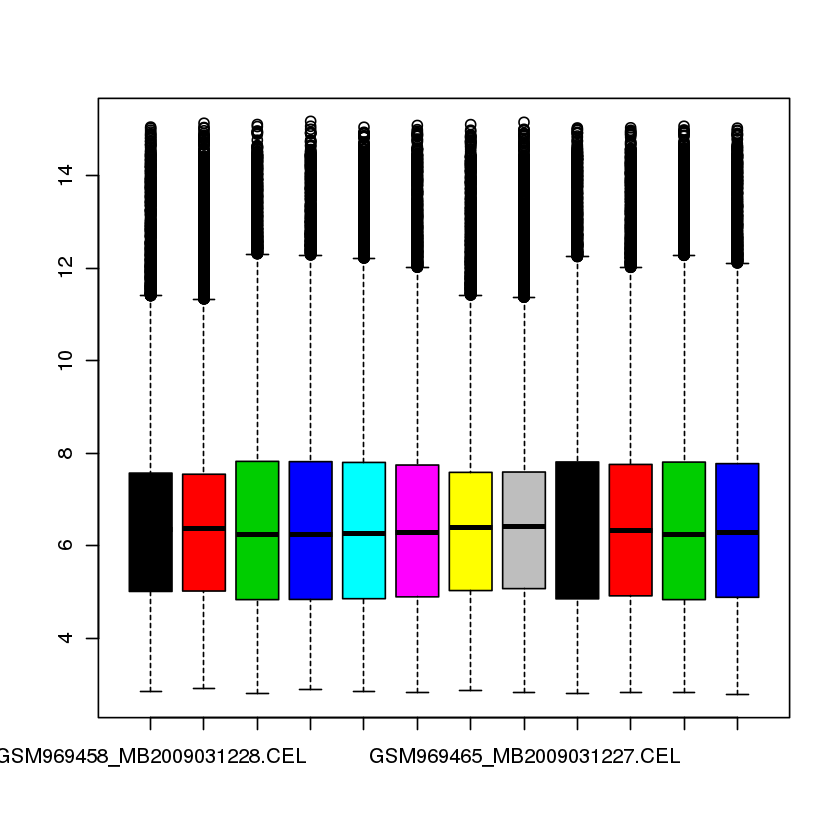

In [56]:
expr.rma <- exprs(data.rma)
boxplot(data.frame(expr.rma), col=c(1:12))

In [6]:
COVs = data.frame(
    cell = rep(c('abl', 'LNCaP'), each=6),
    status = rep(c('control', 'siEZH2'), 6),
    lab = rep(c('VEH', 'DHT'), each = 6),
    rep = rep(rep(0:2, each=2), 2)
)
COVs

cell,status,lab,rep
abl,control,VEH,0
abl,siEZH2,VEH,0
abl,control,VEH,1
abl,siEZH2,VEH,1
abl,control,VEH,2
abl,siEZH2,VEH,2
LNCaP,control,DHT,0
LNCaP,siEZH2,DHT,0
LNCaP,control,DHT,1
LNCaP,siEZH2,DHT,1


In [20]:
X = paste(COVs$status, COVs$cell, sep="_")
design = model.matrix(~0 + X)
colnames(design) = sub("X", "", colnames(design))
contrast_mat = makeContrasts(
    Diff_LNCaP = siEZH2_LNCaP - control_LNCaP,
    Diff_abl = siEZH2_abl - control_abl,
    levels = design
)
limmaFit = lmFit(expr.rma, design) %>%
    contrasts.fit(contrast_mat) %>%
    eBayes() %>%
    tidy

Warning message:
"package 'bindrcpp' was built under R version 3.5.2"

In [24]:
limmaFit = limmaFit %>% group_by(term) %>%
    mutate(fdr = p.adjust(p.value, method = 'fdr')) %>%
    ungroup()

In [27]:
limmaFit %>% arrange(p.value) %>% head()

gene,term,estimate,statistic,p.value,lod,fdr
1555097_a_at,Diff_LNCaP,-1.0107465,-6.574204,4.079951e-05,-3.583943,0.9999766
213906_at,Diff_abl,-0.9347667,-5.981590,9.320478e-05,-3.634084,0.9999573
235013_at,Diff_LNCaP,0.6934413,5.706815,1.389482e-04,-3.660850,0.9999766
218308_at,Diff_abl,-1.1258601,-5.535900,1.790745e-04,-3.678774,0.9999573
225767_at,Diff_LNCaP,0.9100879,5.495122,1.903645e-04,-3.683203,0.9999766
239207_at,Diff_LNCaP,0.6836492,5.442495,2.060654e-04,-3.689009,0.9999766


In [ ]:
genelist = limmaFit %>%
    filter(fdr < 0.05, abs(estimate) >= log2(1.3)) %>%
    distinct(gene)
expr_subset = expr_rma[genelist$gene, ]

# Part 2

In [2]:
taylor <- as.matrix(read.csv("data/taylor2010_data.txt", sep="\t",row.names=1))
index_normal <- grepl("N.P", colnames(taylor))
index_primary <- grepl("P.P", colnames(taylor))
index_met <- grepl("M.P", colnames(taylor))
n_normal <- sum(index_normal);
n_primary = sum(index_primary);
n_met = sum(index_met);

# class label (design vector)
taylor_classes = c(rep(0,n_normal), rep(1,n_primary), rep(2,n_met));

# train (known type samples), and test (unknown type samples)
train <- taylor[,1:174];
test <- taylor[,175:179];

tumortype_all <- factor(c(taylor_classes, rep(3, 5)), levels = 0:3,
                        labels = c("Normal", "Primary", "Metastasized",
                                   "Unknown"))
tumortype_class <- factor(taylor_classes, levels = 0:2,
                          labels = c("Normal", "Primary",
                                     "Metastasized"))

train_samps <- 1:174
test_samps <- 175:179

In [3]:
tumortype_all %>% table(.)

.
      Normal      Primary Metastasized      Unknown 
          27          129           18            5 

In [4]:
print(dim(taylor))
taylor[1:10, 1:10]

[1] 23974   179


,N.PAN0095,N.PAN0107,N.PAN0109,N.PAN0110,N.PAN0112,N.PAN0113,N.PAN0114,N.PAN0115,N.PAN0117,N.PAN0120
A1BG,8.382,8.755,8.795,8.479,8.742,8.844,9.218,8.675,9.132,9.497
A1CF,5.761,5.501,5.352,5.455,5.508,5.197,5.786,5.723,5.814,6.097
A2M,10.945,10.363,11.671,10.456,12.386,9.841,12.154,11.668,11.422,10.482
A2ML1,6.330,6.392,5.869,5.343,5.955,5.107,6.025,5.637,5.839,5.990
A4GALT,8.258,8.493,8.697,8.318,8.729,8.429,8.312,8.293,8.328,8.317
A4GNT,5.924,6.010,5.949,5.737,6.017,5.530,6.199,6.040,6.457,5.838
AAAS,9.602,9.387,9.391,9.398,9.405,9.380,9.432,9.488,9.042,9.179
AACS,8.634,8.778,8.226,8.229,8.249,8.676,7.995,8.173,8.221,8.284
AADACL3,6.879,6.596,6.568,6.712,6.590,6.252,6.243,6.598,6.626,6.571
AADAT,9.696,8.732,8.659,9.279,8.915,8.985,9.138,8.921,9.166,9.157


In [5]:
design = model.matrix(~0 + tumortype_class)
colnames(design) = sub("tumortype_class", "", colnames(design))
contrast_mat = makeContrasts(
    Diff_Prim = Primary - Normal,
    Diff_Meta = Metastasized - Normal,
    levels = design
)

In [6]:
limmaFit = lmFit(taylor[,train_samps], design) %>%
    contrasts.fit(contrast_mat) %>%
    eBayes() %>%
    tidy()

Warning message:
"package 'bindrcpp' was built under R version 3.5.2"

In [7]:
limmaFit = limmaFit %>% group_by(term) %>%
    mutate(fdr = p.adjust(p.value, method = 'fdr')) %>%
    ungroup()

In [8]:
t = limmaFit %>% filter(fdr < 0.05, abs(estimate) >= log2(1.3)) %>% 
    group_by(gene) %>% mutate(N = n())
t %>% with(table(term, N))

           N
term           1    2
  Diff_Meta 4220 1845
  Diff_Prim  606 1845

4220 genes only Differentiate Meta vs Normal    
606 genes only Differentiate Primary vs Normal    
1845 genes in common. 

#### Only take the set of genes in intersect

In [9]:
genelist = t %>% filter(N==2) %>% distinct(gene) %>% t() %>% as.vector()

In [10]:
taylor_subset = taylor[genelist, ]
taylor_subset %>% dim

[1] 1845  179

In [11]:
taylor_km1 <- kmeans(t(taylor_subset), centers = 3, nstart = 10)
data.frame(type = tumortype_all,
           cluster = taylor_km1$cluster) %>%
    table()

              cluster
type            1  2  3
  Normal        1  0 26
  Primary      87 32 10
  Metastasized  1 17  0
  Unknown       0  3  2

#### Take the set of genes in union

In [12]:
genelist2 = t %>% distinct(gene) %>% t() %>% as.vector()
taylor_subset2 = taylor[genelist2, ]
taylor_km2 <- kmeans(t(taylor_subset2), centers = 3, nstart = 10)
data.frame(type = tumortype_all,
           cluster = taylor_km2$cluster) %>%
    table()

              cluster
type            1  2  3
  Normal        1  0 26
  Primary      67  4 58
  Metastasized  0 17  1
  Unknown       0  3  2

The set of genes in intersect seems better differentiation

In [14]:
pca_result <- taylor_subset %>% t() %>% prcomp(center = TRUE, scale. = TRUE)
edata_pc_df <- as.data.frame(pca_result$x)

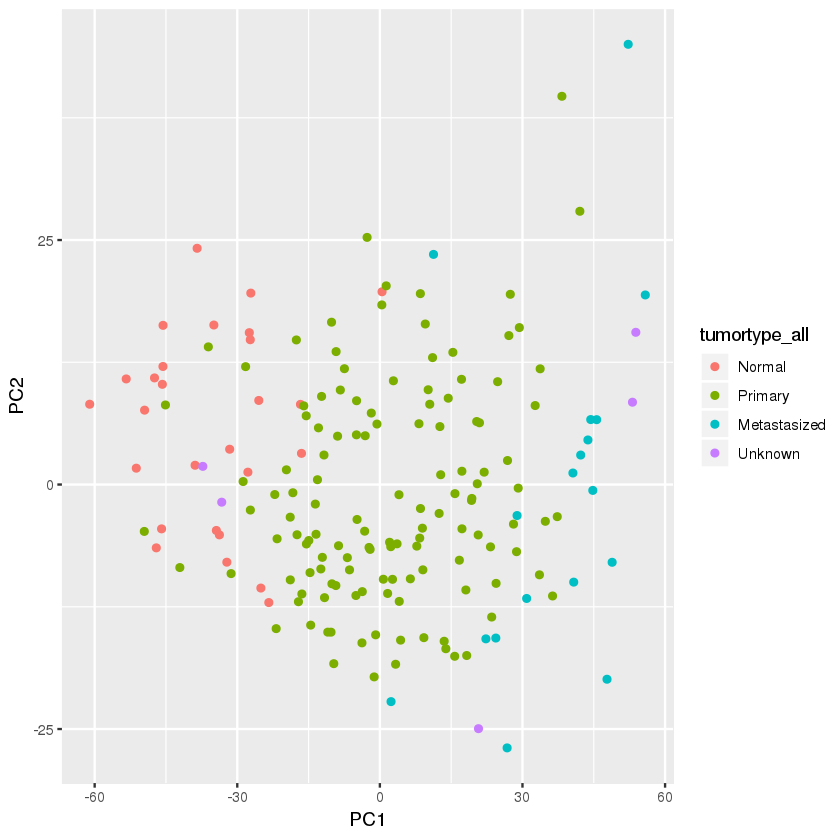

In [17]:
ggplot(edata_pc_df, aes(x = PC1, y = PC2, color = tumortype_all)) +
    geom_point()

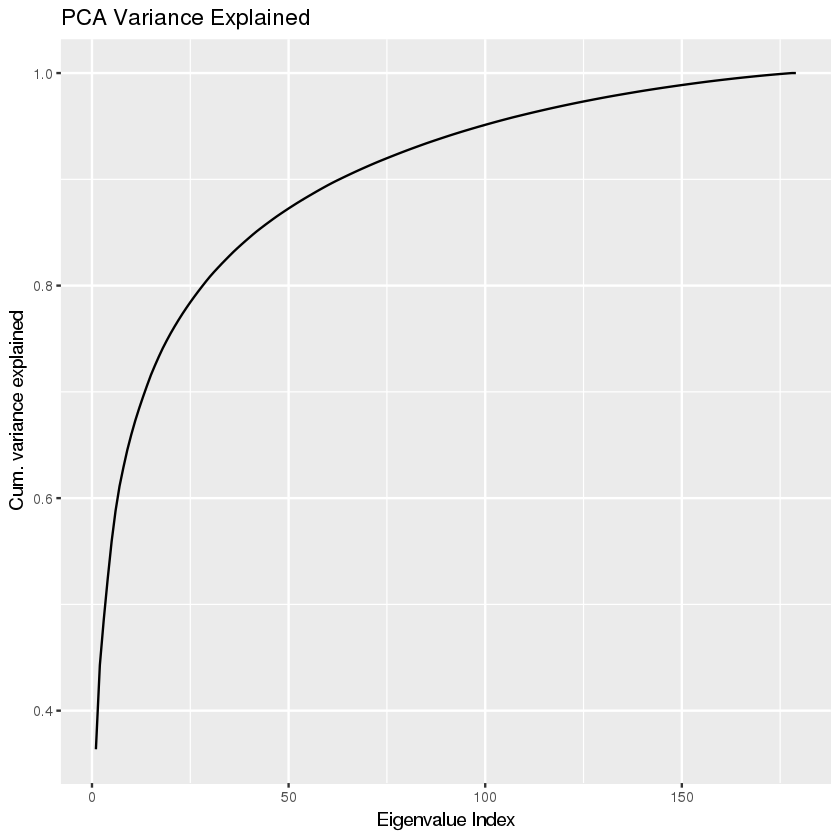

In [15]:
eigenvals <- (pca_result$sdev)^2
n_eigenvals <- length(eigenvals)
var_explained <- cumsum(eigenvals) / sum(eigenvals)
data.frame(index = 1:n_eigenvals,
           var_explained = var_explained) %>%
    ggplot(aes(x = index, y = var_explained)) + geom_line() +
    xlab("Eigenvalue Index") + ylab("Cum. variance explained") +
    ggtitle("PCA Variance Explained")

In [20]:
print(var_explained[1:5])
print(min(which(var_explained > 0.8)))

[1] 0.3636732 0.4427405 0.4858758 0.5241334 0.5593793
[1] 29


#### PCA with all genes

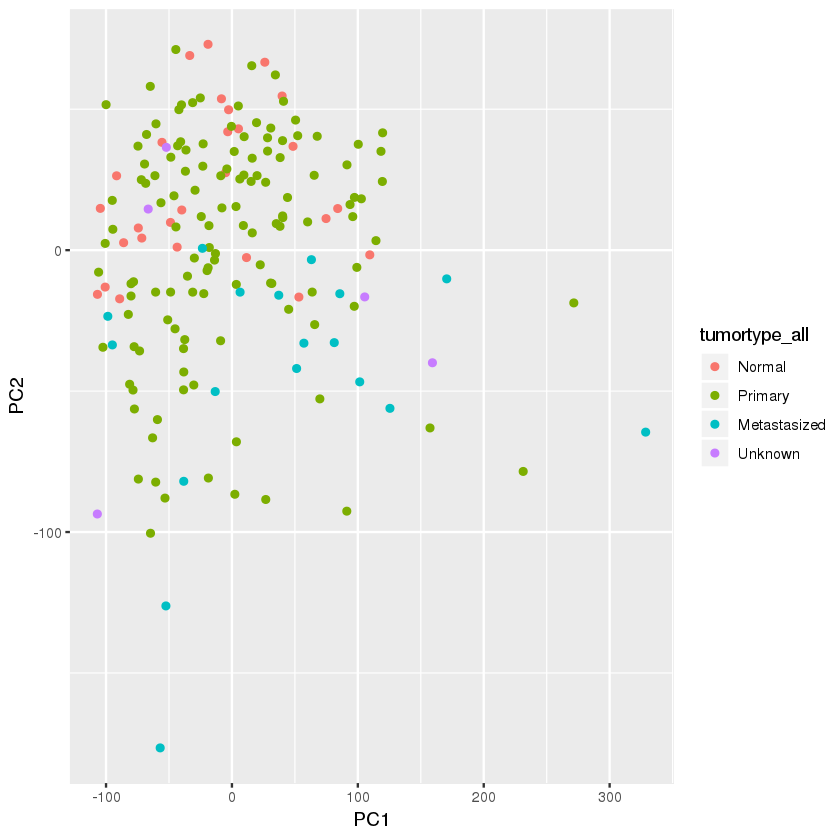

In [19]:
pca_result <- taylor %>% t() %>% prcomp(center = TRUE, scale. = TRUE)
edata_pc_df <- as.data.frame(pca_result$x)
ggplot(edata_pc_df, aes(x = PC1, y = PC2, color = tumortype_all)) +
    geom_point()

#### KNN 1,3,5

In [88]:
N = 120
TRAIN = sample(1:174, N, replace = F)
table(tumortype_class[TRAIN])
knn = knn(t(taylor_subset[,TRAIN]),
            t(taylor_subset[,-TRAIN]),
            tumortype_class[TRAIN], k=1)
sum(tumortype_class[-TRAIN]==knn[1:(174-N)])/(174 -N)
print(knn[(174-N+1):(179 - N)])


      Normal      Primary Metastasized 
          15           91           14 

[1] 0.8888889

[1] Normal       Normal       Metastasized Primary      Metastasized
Levels: Normal Primary Metastasized


In [89]:
knn = knn(t(taylor_subset[,TRAIN]),
            t(taylor_subset[,-TRAIN]),
            tumortype_class[TRAIN], k=3)
sum(tumortype_class[-TRAIN]==knn[1:(174-N)])/(174 -N)
print(knn[(174-N+1):(179 - N)])

[1] 0.9259259

[1] Normal  Normal  Primary Primary Primary
Levels: Normal Primary Metastasized


In [90]:
knn = knn(t(taylor_subset[,TRAIN]),
            t(taylor_subset[,-TRAIN]),
            tumortype_class[TRAIN], k=5)
sum(tumortype_class[-TRAIN]==knn[1:(174-N)])/(174 -N)
print(knn[(174-N+1):(179 - N)])

[1] 0.9074074

[1] Normal       Normal       Primary      Metastasized Primary     
Levels: Normal Primary Metastasized


#### SVM

In [99]:
svm_model = svm(t(taylor_subset[,1:174]), tumortype_class)

In [101]:
predict(svm_model,t(taylor_subset[, 175:179])) %>% print

   Unknown.1    Unknown.2    Unknown.3    Unknown.4    Unknown.5 
      Normal       Normal Metastasized Metastasized Metastasized 
Levels: Normal Primary Metastasized


#### SVM with 3-fold cross-validation

In [130]:
cvlab = rep(0:2, 174/3)
for (i in 0:2){
    TRAIN = which(cvlab!=i)
    TEST = which(cvlab==i)
    svm_model = svm(t(taylor_subset[,TRAIN]), tumortype_class[TRAIN])
    pred = predict(svm_model,t(taylor_subset[, TEST]))
    error = sum(pred != tumortype_class[TEST])/58
    print(error)
}


[1] 0.1034483
[1] 0.06896552
[1] 0.0862069


# Part 3
l3/bwa_demo & l3/STAR_demo